In [1]:
import folium
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import branca

In [2]:
file = open('../pickles/house_latlong.p','rb')
df = pickle.load(file)
location_model = pickle.load(open('../pickles/location_model.p','rb'))

In [3]:
#dropping NA values with lat long. 
df = df[~np.isnan(df.latitude)]
#redo this with the cosine(42) multiplication. 
df['e_long'] = df['longitude']*np.cos(np.radians(42))

In [4]:
ave_lat = np.mean(df.latitude)
ave_long = np.mean(df.longitude)
(ave_lat, ave_long)

(42.034387900593124, -93.64255447330524)

In [5]:
neighborhoods = df[~np.isnan(df.latitude)].groupby('Neighborhood')[['latitude','longitude']].mean() #get center of neighborhood
neighborhoods['num_houses'] = df.Neighborhood.value_counts()
nieghborhoods = neighborhoods.reset_index()

In [10]:
m = folium.Map(location=[ave_lat, ave_long],tiles='Stamen Toner')
for i in range(0,neighborhoods.shape[0]):
    folium.Circle(location = [neighborhoods.latitude[i], neighborhoods.longitude[i]], 
                  radius = int(neighborhoods.num_houses[i]), popup = nieghborhoods.Neighborhood[i]).add_to(m)
m    
    #color the circles

In [7]:
import matplotlib.cm as cmx
import matplotlib.colors as colors
from matplotlib import cm
import branca

m = folium.Map(location=[ave_lat, ave_long],
               boxZoom = True,
               tiles='Stamen Toner')

A = np.linspace(min(df.latitude),max(df.latitude),100)
B = np.linspace(min(df.e_long),max(df.e_long),100)
A, B = np.meshgrid(A, B)

C = location_model.predict(np.transpose(np.array([A.flatten(), B.flatten()])))
B = B / np.cos(np.radians(42))
A = A.flatten(); B = B.flatten()



In [ ]:
# plasma = cm = plt.get_cmap('plasma') 
# cNorm  = colors.Normalize(vmin=0, vmax=max(C))
# scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plasma)
# for i in range(0,A.shape[0]):
#     folium.Circle(location = [A[i], B[i]], 
#                      radius = 50,
#                      fill = True,
#                      color = colors.to_hex(scalarMap.to_rgba(C[i])),
#                      opacity = .4,
#                      fillOpacity = .8
#                      ).add_to(m)

# m

In [8]:
import branca
colormap = branca.colormap.linear.YlOrRd_09.scale(0, max(C))
m = folium.Map(location=[ave_lat, ave_long],
               boxZoom = True, control_scale = True,
               tiles='Stamen Toner')
for i in range(0,A.shape[0]):
    folium.Circle(location = [A[i], B[i]], 
                     radius = 50,
                     fill = True,
                     color = colormap(C[i]),
                     opacity = .35,
                     fillOpacity = .4
                     ).add_to(m)
colormap = colormap.to_step(index=np.linspace(0,max(C),6))
colormap.caption = 'Average House Price in Ames, Iowa'
colormap.add_to(m)
m

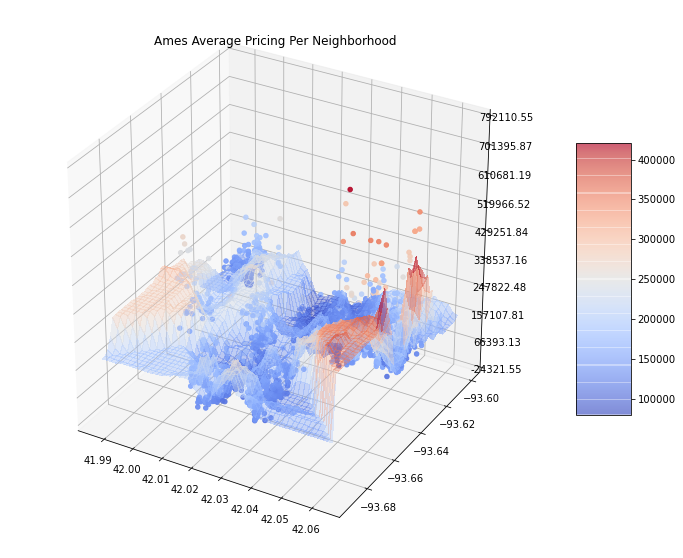

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.colors as colors

plt.rcParams['figure.figsize'] = (12,10)
fig = plt.figure()
ax = fig.gca(projection='3d')

A = np.linspace(min(df.latitude),max(df.latitude),50)

B = np.linspace(min(df.e_long),max(df.e_long),50)
A, B = np.meshgrid(A, B)
C = location_model.predict(np.transpose(np.array([A.flatten(), B.flatten()]))).reshape(A.shape)

# Plot the surface.
surf = ax.plot_surface(A, B/np.cos(np.radians(42)), C, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha = 0.4)
scat2 = ax.scatter(df.latitude, df.longitude, df.SalePrice, c = df.SalePrice,cmap = cm.coolwarm, alpha = 0.9)
# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Ames Average Pricing Per Neighborhood')
plt.show()
fig.savefig('./pic/surfacemap.png', transparent = True)

In [ ]:
gcv_knr.score(x_train[['latitude','e_long']],y_train), KNR.score(x_test[['latitude','e_long']],y_test) 

In [ ]:
lam = .5
x_train['residuals'] = y_train - lam*gcv_knr.predict(x_train[['latitude','e_long']])

In [ ]:
x_train.residuals

### SVR - with RBF Kernels

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [ ]:
SVR_map = make_pipeline(StandardScaler(),SVR(epsilon =.0001 ,C = 100000)) #NEED TO USE GRIDSEARCH!!! Maybe fit toooo
SVR_map.fit(x_train[['latitude','e_long']],y_train)
SVR_map.score(x_train[['latitude','e_long']], y_train), SVR_map.score(x_test[['latitude','e_long']],y_test)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('SalePrice', axis = 1),df['SalePrice'], test_size = .2)

SVR_map = SVR(kernel='rbf') #NEED TO USE GRIDSEARCH!!! Maybe fit toooo

parameters = {'C' : [100,1000,10000,100000,1000000,10000000], 'epsilon' : [.01,.1,1,10,100,1000], 
              'gamma' : [.001,.01,.1,1,10,100,1000,10000,1000000]}

GD_SVR = GridSearchCV(SVR_map,param_grid=parameters)

GD_SVR.fit(x_train[['latitude','e_long']],y_train)

#SVR_map.fit(x_train[['latitude','e_long']],y_train)
#SVR_map.score(x_train[['latitude','e_long']], y_train), SVR_map.score(x_test[['latitude','e_long']],y_test)

In [ ]:
[GD_SVR.cv_results_['params'][x] for x in [i for i, j in enumerate(GD_SVR.cv_results_['mean_test_score']) if j>.6]]
GD_SVR.best_estimator_


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
plt.rcParams['figure.figsize'] = (12,10)
fig = plt.figure()
ax = fig.gca(projection='3d')

A = np.linspace(min(x_train.latitude),max(x_train.latitude),100)

B = np.linspace(min(x_train.e_long),max(x_train.e_long),100)
A, B = np.meshgrid(A, B)
C = GD_SVR.predict(np.transpose(np.array([A.flatten(), B.flatten()]))).reshape(A.shape)

# Plot the surface.
surf = ax.plot_surface(A, B, C, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('the graph of MyFunc')
plt.show()

In [ ]:
x_train['residuals'] = y_train - SVR_map.predict(x_train[['latitude','e_long']])

### Potentially evaluate gradient boosting

In [ ]:
from sklearn.linear_model import Ridge, LinearRegression

house_base_reduced = x_train.loc[:,['GrLivArea','residuals','LotArea',
                      'OverallQual','OverallCond','YearBuilt','YearRemodAdd',
                      'TotalBsmtSF','Fireplaces','GarageArea',
                      'MoSold','YrSold']]
house_base_reduced = pd.get_dummies(house_base_reduced)

house_base_reduced['Age'] = house_base_reduced['YrSold'] - house_base_reduced['YearBuilt'] #think about combining into one
house_base_reduced['YrSinceRemod'] =  house_base_reduced['YrSold'] - house_base_reduced['YearRemodAdd']
house_base_reduced = house_base_reduced.drop(['YrSold','YearBuilt','YearRemodAdd'],axis = 1)

In [ ]:
lm_residuals = Ridge()

In [ ]:
house_base_reduced = house_base_reduced.dropna()

In [ ]:
lm_residuals.fit(house_base_reduced.drop('residuals', axis =1), house_base_reduced['residuals'])

In [ ]:
import statsmodels.api as sm
x = sm.add_constant(house_base_reduced.drop('residuals', axis =1))
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(house_base_reduced['residuals'], x)
results = model.fit()
print(results.summary())

### Unsupervised Clustering

Similar analysis as above but instead use an unsupervised clustering algorithm, then just the average price in that region (think about the type of average to use). Orrrrrrrr do a separate analysis on each cluster? Idk I don't like this. 